In [34]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
from torch_geometric.utils import from_networkx
from ipaddress import IPv4Address
import random
import logging
from torch_geometric.loader import DataLoader
import pickle

# Train Graph

### Load Dataset

In [35]:
filename = './Data/dataset.pt'


dataset = torch.load(filename, weights_only=False)


In [36]:
import torch
from torch_geometric.datasets import TUDataset
from pprint import pprint


print(len(dataset))
data = dataset[10]  # Get the first graph object.

print()
print(data)
print('=============================================================')



# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

11757

Data(edge_index=[2, 22], feature=[6, 110], num_nodes=6, x=[6, 48], y=1)
Number of nodes: 6
Number of edges: 22
Average node degree: 3.67
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [37]:
import random

random.shuffle(dataset)

# Split the dataset into training and test sets
split_ratio = 0.7
split_index = int(len(dataset) * split_ratio)
train_dataset = dataset[:split_index]
test_dataset = dataset[split_index:]




print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
    

Number of training graphs: 8229
Number of test graphs: 3528


In [38]:
ntest = len(test_dataset)
testcount = 0
testlow = 0
testhigh = 0
for t in test_dataset:
    if t.y.item() == 0:
        testcount+=1
    if t.y.item() == 1:
        testlow+=1
    if t.y.item() == 2:
        testhigh+=1

ntrain = len(train_dataset)
traincount = 0
trainlow = 0
trainhigh = 0
for t in train_dataset:
    if t.y.item() == 0:
        traincount+=1
    if t.y.item() == 1:
        trainlow+=1
    if t.y.item() == 2:
        trainhigh+=1

print('--------------Train--------------')
print(f'\033[1mPercent of low privilege compromised graphs: \033[0m{trainlow/ntrain}')
print(f'\033[1mPercent of not compromised graphs: \033[0m{traincount/ntrain}')



print('--------------Test--------------')
print(f'\033[1mPercent of low privilege compromised graphs: \033[0m{testlow/ntest}')
print(f'\033[1mPercent of not compromised graphs: \033[0m{testcount/ntest}')

--------------Train--------------
Percent of low privilege compromised graphs: 0.4369911289342569
Percent of not compromised graphs: 0.5630088710657432
--------------Test--------------
Percent of low privilege compromised graphs: 0.4282879818594104
Percent of not compromised graphs: 0.5717120181405896


### GCN

In [57]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

#Specify device manually
use_gpu = True # Set to False to use CPU
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")


# DataLoader (ensure `train_dataset` and `test_dataset` are loaded correctly)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = len(train_dataset[0].x[0])

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim=input_dim, hidden_channels=32, invert_output=False):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]


        x = self.lin(x)
        x = self.sigmoid(x)

        return x

model = GCN(hidden_channels=32)

# Extract weights from the model
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        weights[name] = param.data.cpu().numpy()

# Print the extracted weights
for layer, weight in weights.items():
    print(f"Layer: {layer}, Weights shape: {weight.shape}")


print(f"Model initialized on {device}")
print(f"Input dimension: {input_dim}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Using device: cpu
Layer: conv1.bias, Weights shape: (32,)
Layer: conv1.lin.weight, Weights shape: (32, 48)
Layer: conv2.bias, Weights shape: (32,)
Layer: conv2.lin.weight, Weights shape: (32, 32)
Layer: conv3.bias, Weights shape: (32,)
Layer: conv3.lin.weight, Weights shape: (32, 32)
Layer: lin.weight, Weights shape: (2, 32)
Layer: lin.bias, Weights shape: (2,)
Model initialized on cpu
Input dimension: 48
Number of parameters: 3746


In [40]:
from sklearn.metrics import precision_score, recall_score


# Initialize the model, optimizer, and loss function
model = GCN(hidden_channels=64).to(device)  # Move model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

losses = []  # Training losses
test_losses = []  # Test losses
accs = []  # Test accuracies
precisions = []  # Test precisions
recalls = []  # Test recalls
train_accs = []  # Training accuracies


# Define the training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)  # Move batch data to GPU
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        total_loss += loss.item()  # Accumulate loss for this epoch.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    
    # Print the accuracy for the current batch
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = int((pred == data.y).sum())  # Check against ground-truth labels.
    acc = correct / len(data.y)  # Derive ratio of correct predictions.
    train_accs.append(acc)  # Append accuracy to the list.
    avg_loss = total_loss / len(train_loader)  # Calculate average loss for this epoch.
    losses.append(avg_loss)  # Append the average loss to the list.

# Define the testing loop
def test(loader):
    model.eval()
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation during evaluation.
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)  # Move batch data to GPU
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)  # Compute the loss for the batch.
            total_loss += loss.item()  # Accumulate test loss.
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.

            # Collect predictions and true labels for precision and recall
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    avg_loss = total_loss / len(loader)  # Calculate average test loss.
    test_losses.append(avg_loss)  # Append the average test loss to the list.
    acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
    accs.append(acc)  # Append accuracy to the list.

    # Compute precision and recall
    precision = precision_score(all_labels, all_preds, average='macro',zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    precisions.append(precision)
    recalls.append(recall)

    return acc, avg_loss, precision, recall

# Training and testing loop
for epoch in range(1, 11):
    train()
    test_acc, test_loss, precision, recall = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {losses[-1]:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')


Epoch: 001, Train Loss: 0.6591, Test Loss: 0.5246, Train Acc: 0.7297, Test Acc: 0.8243, Precision: 0.8255, Recall: 0.8138
Epoch: 002, Train Loss: 0.5236, Test Loss: 0.4269, Train Acc: 0.8378, Test Acc: 0.8982, Precision: 0.8989, Recall: 0.8928
Epoch: 003, Train Loss: 0.4549, Test Loss: 0.3964, Train Acc: 0.8649, Test Acc: 0.9238, Precision: 0.9243, Recall: 0.9197
Epoch: 004, Train Loss: 0.4292, Test Loss: 0.3825, Train Acc: 0.9730, Test Acc: 0.9365, Precision: 0.9374, Recall: 0.9329
Epoch: 005, Train Loss: 0.4073, Test Loss: 0.3736, Train Acc: 0.9189, Test Acc: 0.9427, Precision: 0.9454, Recall: 0.9380
Epoch: 006, Train Loss: 0.3939, Test Loss: 0.3682, Train Acc: 1.0000, Test Acc: 0.9481, Precision: 0.9522, Recall: 0.9427
Epoch: 007, Train Loss: 0.3884, Test Loss: 0.3620, Train Acc: 0.8649, Test Acc: 0.9527, Precision: 0.9563, Recall: 0.9477
Epoch: 008, Train Loss: 0.3821, Test Loss: 0.3589, Train Acc: 0.8919, Test Acc: 0.9532, Precision: 0.9569, Recall: 0.9483
Epoch: 009, Train Loss: 

## Graphs

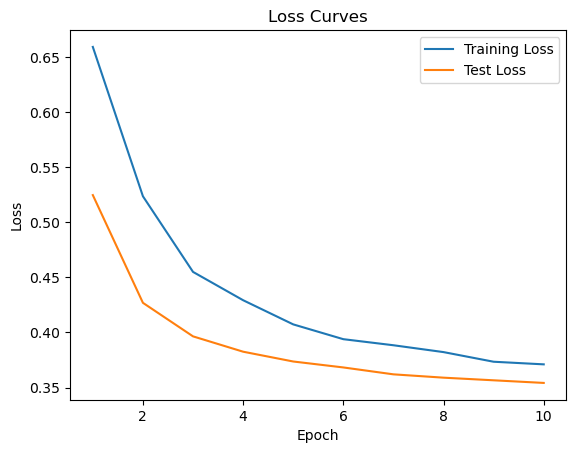

In [41]:
# Plot the loss curve
plt.plot(range(1, 11), losses, label='Training Loss')
plt.plot(range(1,11), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.show()


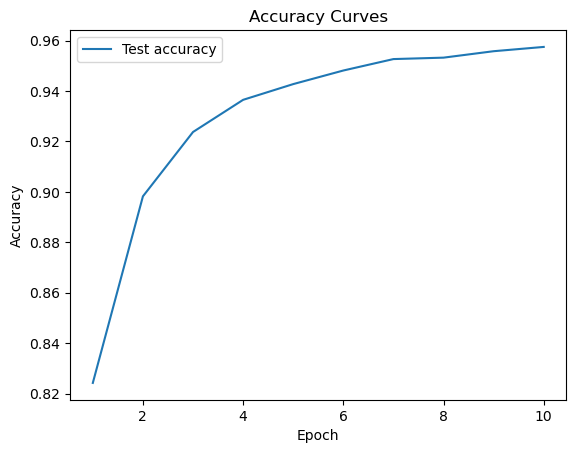

In [42]:
plt.plot(range(1, 11), accs, label='Test accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()


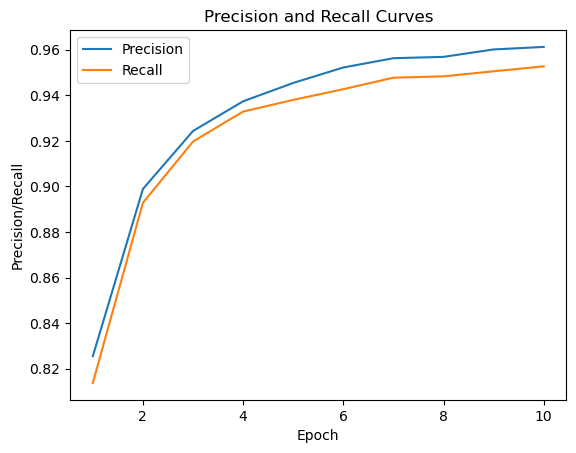

In [43]:
plt.plot(range(1, 11), precisions, label='Precision')
plt.plot(range(1, 11), recalls, label='Recall')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall Curves')
plt.show()

## Python to Matlab

In [14]:
dataset = torch.load('Data/dataset.pt', weights_only=False) 

In [36]:
import torch
import numpy as np
from scipy.io import savemat
from torch_geometric.utils import to_dense_adj



# Prepare plain Python lists for each attribute
edge_indices = []
features = []
labels = []

# Iterate through each Data object in the dataset
for data in dataset:
    # Convert to NumPy arrays if needed
    edge_index = data.edge_index.numpy() if isinstance(data.edge_index, torch.Tensor) else data.edge_index
    feature = data.x.numpy() if isinstance(data.x, torch.Tensor) else data.x
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
    adj_matrix = to_dense_adj(edge_index_tensor)[0].numpy()
    edge_index = adj_matrix
    label = data.y.numpy() if isinstance(data.y, torch.Tensor) else data.y

    num_nodes = feature.shape[0]

    edge_indices.append(edge_index)
    features.append(feature)
    labels.append(label)

# Manually create object arrays to avoid broadcasting issues
edge_indices_obj = np.empty(len(edge_indices), dtype=object)
features_obj = np.empty(len(features), dtype=object)
labels_obj = np.empty(len(labels), dtype=object)

for i in range(len(edge_indices)):
    edge_indices_obj[i] = edge_indices[i]
    features_obj[i] = features[i]
    labels_obj[i] = labels[i]

# Build the dictionary for saving to .mat
data_dict = {
    'edge_indices': edge_indices_obj,  # Now an object array (MATLAB cell array)
    'features': features_obj,          # Object array of feature matrices
    'labels': labels_obj               # Object array of labels
}

# Save to .mat file
savemat('converted_dataset.mat', data_dict)
print("Conversion to .mat complete!")


Conversion to .mat complete!


# Topological Pertubations

In [44]:
import torch
import numpy as np
import os.path as osp
import tempfile
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.data.makedirs import makedirs
# from robograph.model.gnn import GCNConv, train, eval
from tqdm.notebook import tqdm
from robograph.utils import process_data, cal_logits

from robograph.attack.admm import admm_solver_doubleL
from robograph.attack.cvx_env_solver import cvx_env_solver
from robograph.attack.dual import dual_solver_doubleL
from robograph.attack.greedy_attack import Greedy_Attack
from robograph.attack.utils import calculate_Fc
from robograph.attack.convex_relaxation import ConvexRelaxation

In [71]:
torch.manual_seed(0)
np.random.seed(0)

# Move model to evaluation mode
model.eval()



# Ensure model is on the correct device
model = model.to(device)


W = np.random.randn(48, 32)
U = np.random.randn(48, 32)


# counter of certifiably robust and vulnerable 
robust_dual = 0
robust_cvx_DL = 0
robust_cvx_SL = 0
vul_admm_g = 0
vul_greedy = 0

# counter of correct classification
correct = 0

# attacker settings
strength = 3
delta_g = 10

# setting for solvers
dual_params = dict(iter=100, verbose=0, nonsmooth_init='random')
cvx_params = dict(iter=400, lr=0.3, verbose=0, constr='1+2+3', 
                 activation='relu', algo='swapping', nonsmooth_init='subgrad')
admm_params = dict(iter=200, mu=1)

for data in tqdm(test_dataset, desc='across graphs'):
    A, X, y = process_data(data)
    deg = A.sum(1)
    n_nodes = A.shape[0]
    n_edges = np.count_nonzero(A) // 2
    
    delta_l = np.minimum(np.maximum(deg - np.max(deg) + strength, 0), n_nodes - 1).astype(int)
    # delta_g
    
    logits = cal_logits(A, X@W, U, act='relu')
    c_pred = logits.argmax()
    
    if c_pred != y:
        continue
    correct += 1
    fc_vals_orig = [0] * k
    fc_vals_dual = [0] * k
    fc_vals_cvx_DL = [0] * k
    fc_vals_cvx_SL = [0] * k
    fc_vals_admm = [0] * k
    fc_vals_admm_g = [0] * k
    fc_vals_greedy = [0] * k
    
    
    for c in tqdm(range(k), desc='across labels', leave=False):
        if c == y:
            continue
        u = U[y] - U[c]
        XW = X@W
        
        # fc_val_orig
        fc_vals_orig[c] = calculate_Fc(A, XW, u / n_nodes, activation='relu')
        
        # fc_val_dual
        cvx_relax = ConvexRelaxation(A, XW, u / n_nodes, delta_l, delta_g, 'relu', 'envelop', 'doubleL')
        dual_sol = dual_solver_doubleL(A, cvx_relax.Q, cvx_relax.p, 
                                       delta_l=delta_l, delta_g=delta_g, **dual_params)
        fc_vals_dual[c] = dual_sol['opt_f']
        
        # fc_val_cvx_DL
        cvx_env_params = dict(iter=100, lr=1, verbose=0, constr='1+2+3', nonsmooth_init='subgrad',
                                  activation='relu', algo='swapping', relu_bound='doubleL')
        cvx_env_doubleL_sol = cvx_env_solver(A, XW, u / n_nodes, delta_l, delta_g, **cvx_env_params)
        fc_vals_cvx_DL[c] = cvx_env_doubleL_sol['opt_f']
        
        # fc_val_cvx_SL
        cvx_env_params = dict(iter=100, lr=1, verbose=0, constr='1+2+3', nonsmooth_init='subgrad',
                                  activation='relu', algo='swapping', relu_bound='singleL')
        cvx_env_singleL_sol = cvx_env_solver(A, XW, u / n_nodes, delta_l, delta_g, **cvx_env_params)
        fc_vals_cvx_SL[c] = cvx_env_singleL_sol['opt_f']
        
        # fc_val_admm
        Q, p = cvx_relax.doubleL_ub_coefficient()
        admm_params['init_B'] = dual_sol['opt_A'].copy()
        admm_sol = admm_solver_doubleL(A, Q, p, delta_l, delta_g, **admm_params)
        fc_vals_admm[c] = admm_sol['opt_f']
        
        # fc_val_admm_g: admm + greedy
        admm_g_attack = Greedy_Attack(A, XW, u / n_nodes, delta_l=delta_l, delta_g=delta_g, activation='relu')
        if np.array_equal(admm_sol['opt_A'], admm_sol['opt_A'].T):
            admm_A = admm_sol['opt_A']
        else:
            admm_A = np.minimum(admm_sol['opt_A'], admm_sol['opt_A'].T)
        admm_g_sol = admm_g_attack.attack(admm_A)  # init from A
        fc_vals_admm_g[c] = admm_g_sol['opt_f']
        
        # fc_val_greedy
        attack = Greedy_Attack(A, XW, u / n_nodes, delta_l=delta_l, delta_g=delta_g, activation='relu')
        greedy_sol = attack.attack(A)  # init from A
        fc_vals_greedy[c] = greedy_sol['opt_f']
    
    if np.min(fc_vals_dual) >= 0:
        robust_dual += 1
    if np.min(fc_vals_cvx_DL) >= 0:
        robust_cvx_DL += 1
    if np.min(fc_vals_cvx_SL) >= 0:
        robust_cvx_SL += 1
    if np.min(fc_vals_admm_g) < 0:
        vul_admm_g += 1
    if np.min(fc_vals_greedy) < 0:
        vul_greedy += 1

across graphs:   0%|          | 0/3528 [00:00<?, ?it/s]

AxisError: axis 1 is out of bounds for array of dimension 0